Imports and load data

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import statistics
import numpy as np
import seaborn as sns

basepath = "Evaluated/"
datasets = {
    "dataset": "evaluated-dataset-371519.csv",
    "gpt2-custom": "evaluated-generated-1000.csv",
    "gpt2-org": "evaluated-gpt-1000.csv",
    "poems": "evaluated-poems-573.csv"
}
bag_of_words = dict()

for element, value in datasets.items():
    datasets[element] = pd.read_csv(basepath + value)
    bag_of_words[element] = pd.read_csv(basepath + value.replace(".csv", "-bagofwords.csv"), index_col=0).sort_values(by=['freq'], ascending=False)

datasets["dataset"] = datasets["dataset"][-170000:]

Plot The data

In [2]:
def kdeplot(datasets, key, title, label, **kwargs):

        plt.figure(figsize=(12, 6), dpi=80)

        plt.xlim(0, np.quantile([np.quantile(data[key], 0.995) for data in datasets.values()], 0.2))
        # plt.xlim(0, np.quantile([np.quantile(data[key], 0.995) for data in datasets.values()], 0.20))
        #ylim = dict()
        for name, data in datasets.items():
            #ylim[name] = plt.gca().get_ylim()
            if name == "dataset":
                fig = sns.kdeplot(data[key], shade=True, linewidth=2, label=name, bw_adjust=2.5)
            else:
                fig = sns.kdeplot(data[key], shade=True, linewidth=2, label=name, bw_adjust=1)
        if "ylim" in kwargs:
            plt.ylim(kwargs["ylim"])
        plt.legend(loc='upper right')
        plt.title(title)
        plt.xlabel(label)
        plt.ylabel("Häufigkeit")
        plt.yticks([])
        plt.show()




def hist(datasets, key, title, label):
    plt.figure(figsize=(12, 6), dpi=80)
    key = "lines"

    delimn = max([np.quantile(data[key], 0.995) for data in datasets.values()])
    plt.xlim(0, delimn)
    for name, data in datasets.items():
        plt.hist(data[key], weights=np.ones(len(data[key])) / len(data[key]), bins= int(delimn / 1.5), alpha=1, label=name)

    plt.legend(loc='upper right')
    plt.xlabel('Anzahl Verse')
    plt.ylabel('Wahrscheinlichkeitsdichte')
    plt.title('Verse')
    plt.show()

def hist_bow(top, source, dest):
    labels = bag_of_words[source][:top].index.tolist()
    for label in bag_of_words[dest][:top].index.tolist():
        if label not in labels:
            labels.append(label)

    temp_org, temp_gen = bag_of_words[source]["freq"].to_dict() , bag_of_words[dest]["freq"].to_dict()
    values_org, values_gen = list(), list()
    for key in labels:
        values_org.append(temp_org[key])
        values_gen.append(temp_gen[key])

    delim = len(labels) - top
    x = np.arange(len(labels))  # the label locations
    width = 0.35  # the width of the bars

    fig, ax = plt.subplots(figsize=(12, 6), dpi=80)
    rects1 = ax.bar(x - width/2, values_org, width, label=source)
    rects2 = ax.bar(x + width/2, values_gen, width, label=dest)

    # Add some text for labels, title and custom x-axis tick labels, etc.
    ax.set_ylabel('Häufigkeit')
    ax.set_title(f'Top {top} Wörter (+{delim})')
    ax.set_xticks(x)
    ax.set_xticklabels(labels)
    ax.legend()

    xtickslocs = ax.get_xticks()
    ymin, _ = ax.get_ylim()
    pos = ax.transData.transform([(xtick, ymin) for xtick in xtickslocs])[-delim][0]

    x_line = ax.containers[1][-delim-1].get_xy()[0] + ax.containers[1][-delim-1].get_width() + 0.15
    plt.axvline(x_line, color='k', linestyle='dashed', linewidth=1)
    min_ylim, max_ylim = plt.ylim()
    plt.text(x_line+0.1, max_ylim*0.8, "Generiert, Top "+str(top)+" zusätzlich")
    plt.show()

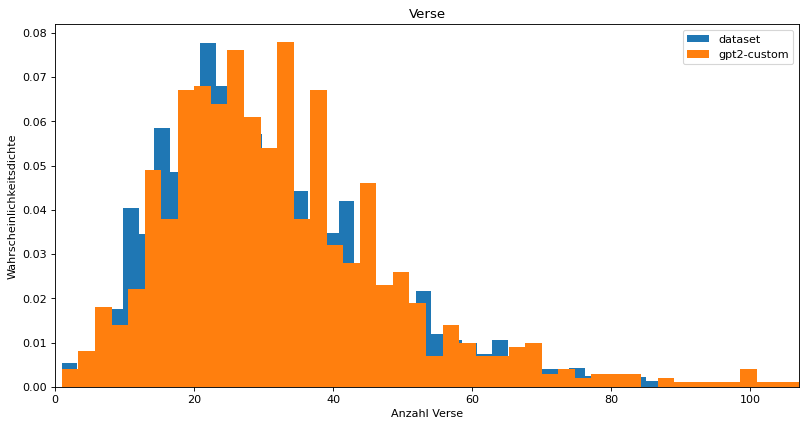

In [131]:
hist({your_key: datasets[your_key] for your_key in ["dataset", "gpt2-custom"] }, "lines", "Verse", "Anzahl Verse")

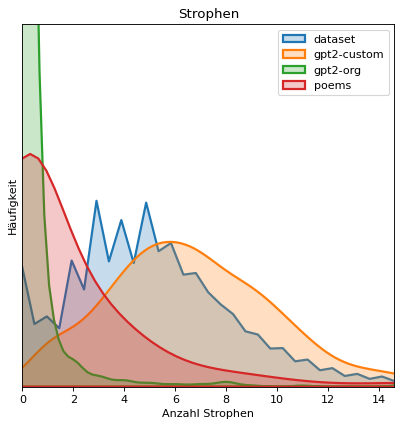

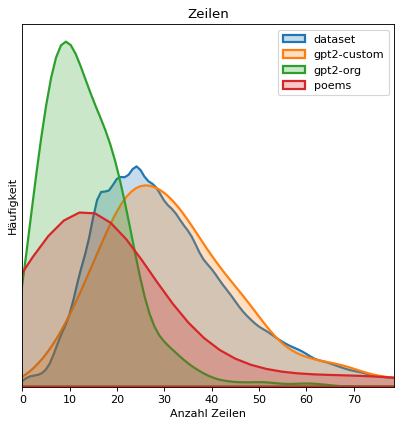

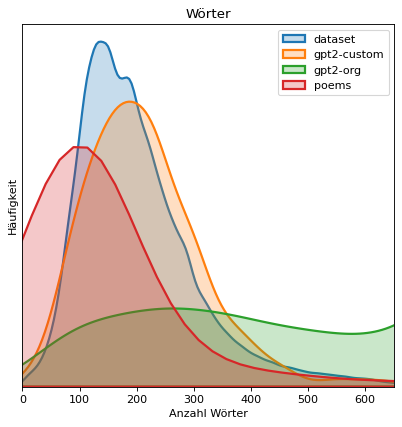

In [70]:
kdeplot(datasets, "strophes", "Strophen", "Anzahl Strophen", ylim=(0, 0.3))
kdeplot(datasets, "lines", "Zeilen", "Anzahl Zeilen")
kdeplot(datasets, "words", "Wörter", "Anzahl Wörter")

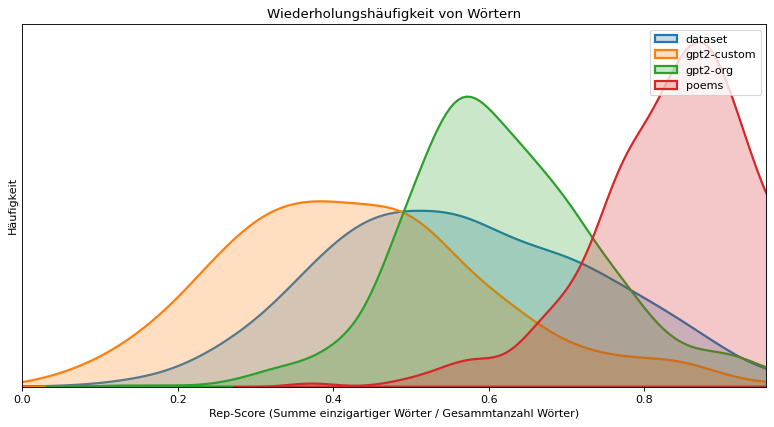

In [223]:
kdeplot(datasets, "repscores", "Wiederholungshäufigkeit von Wörtern", "Rep-Score (Summe einzigartiger Wörter / Gesammtanzahl Wörter)")

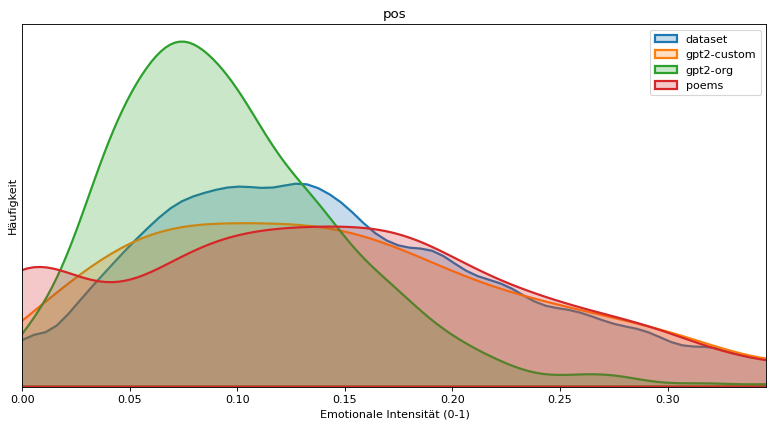

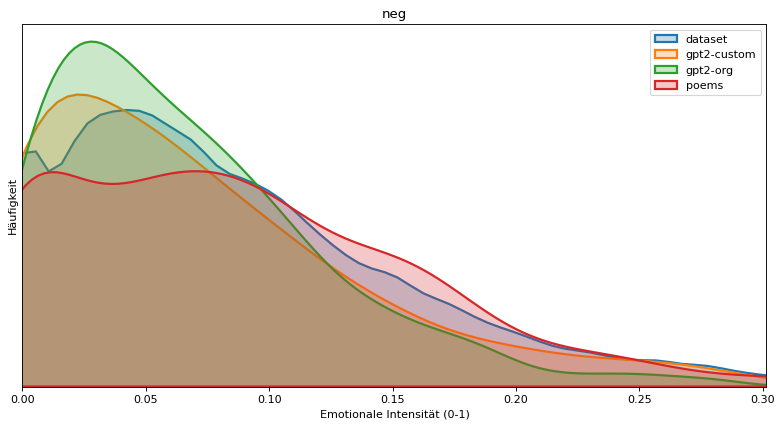

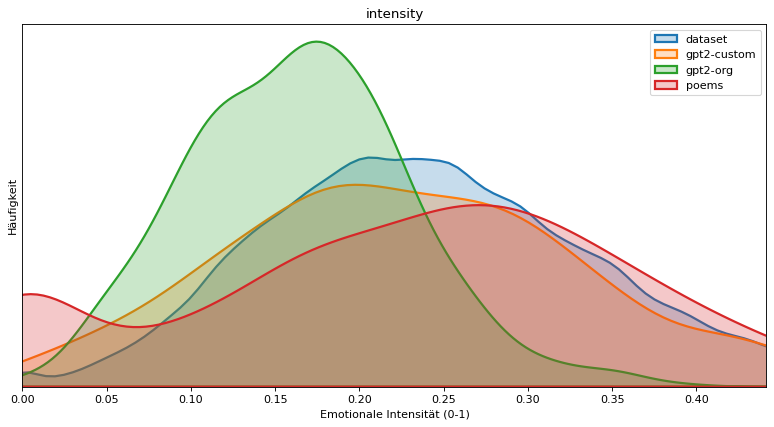

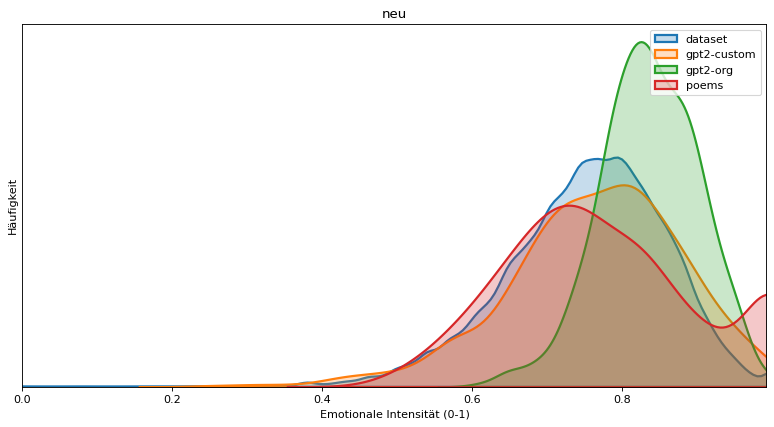

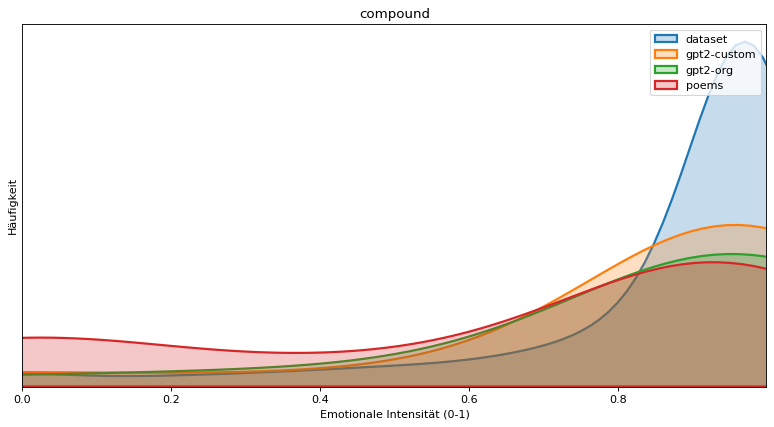

In [231]:
for key in ["pos", "neg", "intensity", "neu", "compound"]:
    kdeplot(datasets, key, key, "Emotionale Intensität (0-1)")

Text(0, 0.5, 'Häufigkeit')

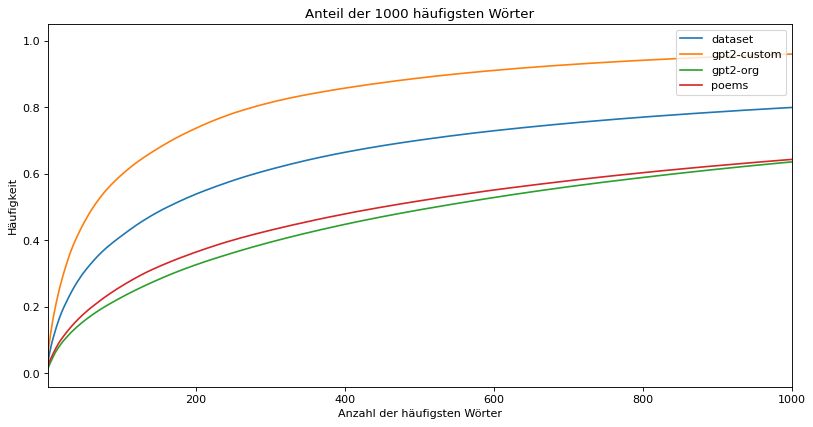

In [8]:
delimn = 1000
plt.figure(figsize=(12, 6), dpi=80)
# test = bag_of_words["dataset"]["freq"].to_dict()
for name, data in bag_of_words.items():
    print()
    plt.plot(data["freq"].cumsum().tolist(), label=name)

plt.legend(loc='upper right')
plt.title(f'Anteil der {delimn} häufigsten Wörter')
#plt.xscale('log')
plt.xlim(1, delimn)
plt.xlabel(f'Anzahl der häufigsten Wörter')
plt.ylabel('Häufigkeit')

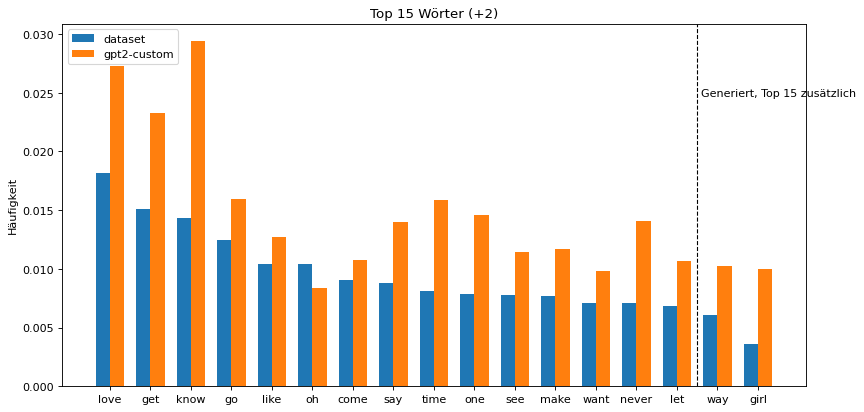

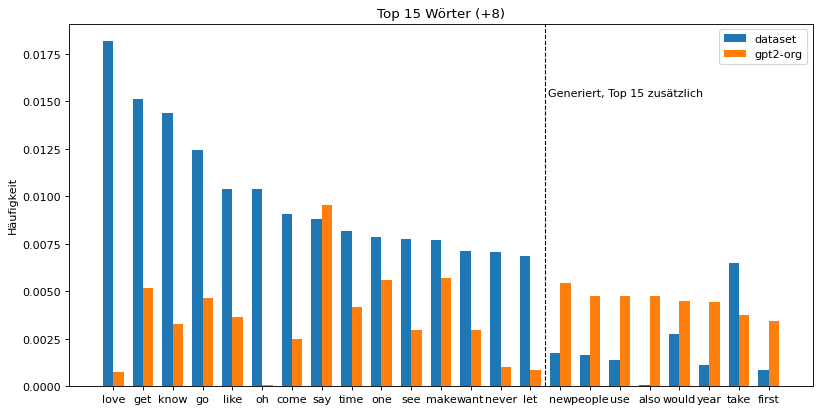

In [201]:
hist_bow(top=15, source="dataset", dest="gpt2-custom")
hist_bow(top=15, source="dataset", dest="gpt2-org")

Datensatz Training mit Validierung vergleichen (dataset[0:201518] <->dataset
-> Median, Durschschnitt & Standartabweichung für jede Metrik ermitteln

In [16]:
training = pd.read_csv("Evaluated/" + "evaluated-dataset-371519.csv")[0:201518]
#validation = pd.read_csv("Evaluated/" + "evaluated-dataset-371519.csv")[201519:371519]
validation = pd.read_csv("Evaluated/" + "evaluated-generated-1000.csv")

def get_statistics(training, validation):
    stats_t, stats_v = dict(), dict()
    stats_t["mean"], stats_v["mean"] = f'{statistics.mean(training):.5f}'[:-1], f'{statistics.mean(validation):.5f}'[:-1]
    stats_t["median"], stats_v["median"] = f'{statistics.median(training):.5f}'[:-1], f'{statistics.median(validation):.5f}'[:-1]
    stats_t["stdev"], stats_v["stdev"] = f'{statistics.stdev(training):.5f}'[:-1], f'{statistics.stdev(validation):.5f}'[:-1]
    return stats_t, stats_v

In [47]:
val = pd.read_csv("Evaluated/" + "evaluated-dataset-371519.csv")[201519:371519]
def get_vals(dataset):
    list_mean = list()
    list_median = list()
    list_stdev = list()
    list_mean_a = list()
    list_median_a = list()
    list_stdev_a = list()
    for key in ["strophes", "lines", "words", "repscores", "compound", "intensity"]:
        mean , mean_val = statistics.mean(dataset[key]), statistics.mean(val[key])
        list_mean.append(mean)
        list_mean_a.append((mean - mean_val) / mean_val)
        median, median_val = statistics.median(dataset[key]), statistics.median(val[key])
        list_median.append(median)
        list_median_a.append((median - median_val) / median_val)
        stdev, stdev_val = statistics.stdev(dataset[key]), statistics.stdev(val[key])
        list_stdev.append(stdev)
        list_stdev_a.append((stdev - stdev_val) / stdev_val)
    dict_temp = {"Durchschnitt": list_mean, "Median": list_median, "Standardabweichung": list_stdev, "Ø Abweichung": list_mean_a, "˜x Abweichung": list_median_a, "σ Abweichung": list_stdev_a }
    df = pd.DataFrame(dict_temp, index=["Anzahl Strophen", "Anzahl Zeilen", "Anzahl Wörter", "WW-Verhältnis", "Em-Polarität", "Em-Intensität"])
    return df


In [73]:
#print("Trainingsdaten")
# val = pd.read_csv("Evaluated/" + "evaluated-dataset-371519.csv")[0:201518]
#df1
#print("Trainingsdaten")

df = get_vals(pd.read_csv("Evaluated/" + "evaluated-generated-1000.csv"))

# df = get_vals(pd.read_csv("Evaluated/" + "evaluated-gpt-1000.csv"))
# df = get_vals(pd.read_csv("Evaluated/" + "evaluated-poems-573.csv"))
#df.to_csv("poems_scores.csv", encoding="utf-8")
df

,Durchschnitt,Median,Standardabweichung,Ø Abweichung,˜x Abweichung,σ Abweichung
Anzahl Strophen,6.857000,6.000000,3.739055,0.321764,0.200000,0.016508
Anzahl Zeilen,33.076000,30.000000,17.851972,0.053761,0.071429,0.100291
Anzahl Wörter,215.837000,201.000000,109.436908,0.064225,0.104396,0.038291
WW-Verhältnis,0.431384,0.420229,0.175114,-0.234423,-0.241761,0.004547
Em-Polarität,0.428672,0.935800,0.771401,0.169742,0.053829,-0.031062
Em-Intensität,0.235959,0.226000,0.117881,-0.045512,-0.054393,0.116838


In [17]:
print(f"Length Training: {len(training)}, Length Validation: {len(validation)}")
print("Strophen: ", get_statistics(training["strophes"], validation["strophes"]))
print("Verse: ", get_statistics(training["lines"], validation["lines"]))
print("Words: ", get_statistics(training["words"], validation["words"]))
print("Rep Scores: ", get_statistics(training["repscores"], validation["repscores"]))
print("Emotional Ploarity: ", get_statistics(training["compound"], validation["compound"]))
print("Emotional intensity: ", get_statistics(training["intensity"], validation["intensity"]))




Length Training: 201518, Length Validation: 1000
Strophen:  ({'mean': '5.1693', 'median': '5.0000', 'stdev': '3.6221'}, {'mean': '6.8570', 'median': '6.0000', 'stdev': '3.7390'})
Verse:  ({'mean': '31.2182', 'median': '28.0000', 'stdev': '15.9273'}, {'mean': '33.0760', 'median': '30.0000', 'stdev': '17.8519'})
Words:  ({'mean': '201.7592', 'median': '183.0000', 'stdev': '101.9322'}, {'mean': '215.8370', 'median': '201.0000', 'stdev': '109.4369'})
Rep Scores:  ({'mean': '0.5626', 'median': '0.5531', 'stdev': '0.1751'}, {'mean': '0.4313', 'median': '0.4202', 'stdev': '0.1751'})
Emotional Ploarity:  ({'mean': '0.3634', 'median': '0.8860', 'stdev': '0.7970'}, {'mean': '0.4286', 'median': '0.9358', 'stdev': '0.7714'})
Emotional intensity:  ({'mean': '0.2474', 'median': '0.2390', 'stdev': '0.1058'}, {'mean': '0.2359', 'median': '0.2260', 'stdev': '0.1178'})


0.94194155
mean: 0.74702742415
median: 0.7608961249999999
stdev: 0.10597795216413065
0.483047635


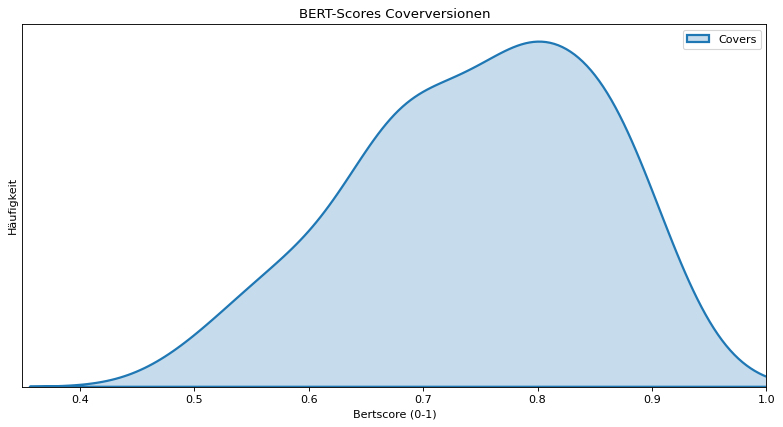

In [4]:

df_bertscores = pd.read_csv("org_cover.csv")["Score"].tolist()
sc = list()


for score in df_bertscores:
    sc.append(float(float(score) / 2))

print(max(sc))
print("mean:", statistics.mean(sc))
print("median:", statistics.median(sc))
print("stdev:", statistics.stdev(sc))
print(min(sc))
plt.figure(figsize=(12, 6), dpi=80)
fig = sns.kdeplot(sc, shade=True, linewidth=2, label="Covers", bw_adjust=1)
plt.legend(loc='upper right')
plt.title("BERT-Scores Coverversionen")
plt.xlim(0.35, 1)
plt.xlabel("Bertscore (0-1)")
plt.ylabel("Häufigkeit")
plt.yticks([])
plt.show()
#kdeplot(df_bertscores["Score"], "lines", "Zeilen", "Anzahl Zeilen")

In [130]:
def kdeplot_one(data, title, label, ylabel, name):

    plt.figure(figsize=(6, 6), dpi=80)
    fig = sns.kdeplot(data, shade=True, linewidth=2, label=name, bw_adjust=1, clip=(0.0, 1.0))
    # fig = sns.distplot(data, hist=False, label=name, kde_kws={'clip': (0.0, 1.0)})
    plt.legend(loc='upper right')
    plt.xlim(0.0, 1.0)
    plt.title(title)
    plt.xlabel(label)
    plt.ylabel(ylabel)
    plt.yticks([])
    plt.show()

def kdeplot_two(data, data2, title, label, ylabel, name, name2):

    plt.figure(figsize=(6, 6), dpi=80)
    fig = sns.kdeplot(data, shade=True, linewidth=2, label=name, bw_adjust=1, clip=(0.0, 1.0))
    fig = sns.kdeplot(data2, shade=True, linewidth=2, label=name2, bw_adjust=1, clip=(0.0, 1.0))
    # fig = sns.distplot(data, hist=False, label=name, kde_kws={'clip': (0.0, 1.0)})
    plt.legend(loc='upper right')
    plt.xlim(0.0, 1.0)
    plt.title(title)
    plt.xlabel(label)
    plt.ylabel(ylabel)
    plt.yticks([])
    plt.show()

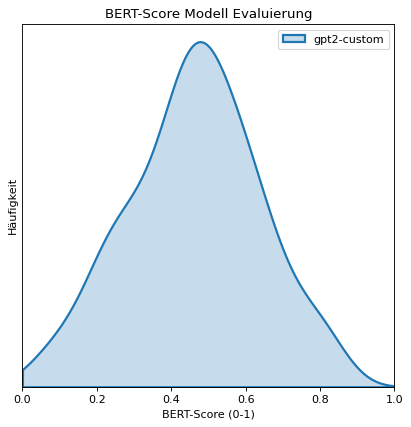

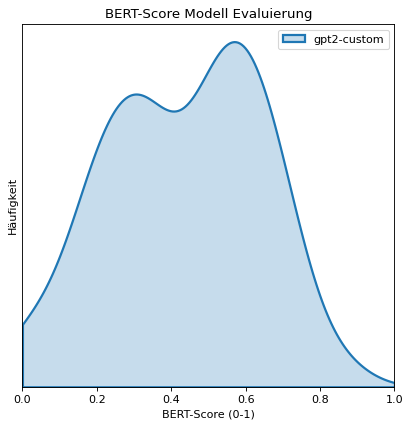

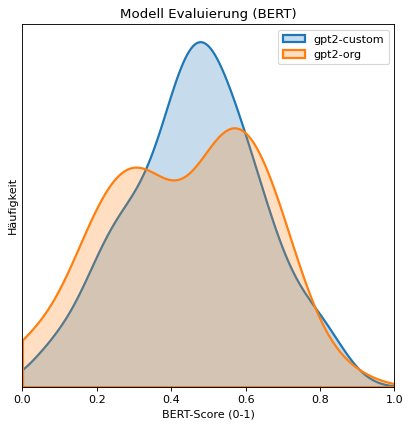

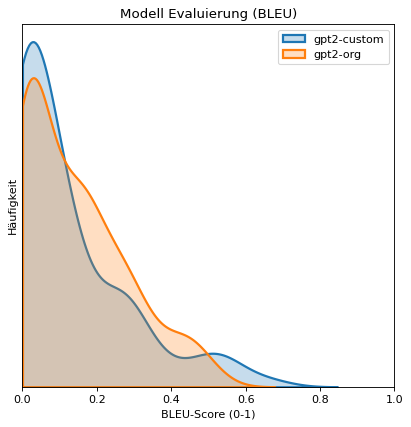

mean: 0.46174387394 median: 0.46604347 stdev: 0.17342293115465113
mean: 0.12123294366049274 median: 0.06201313611814835 stdev: 0.1554566395647066
org
mean: 0.4332423411 median: 0.47089784 stdev: 0.20450430691527266
mean: 0.1385138625245065 median: 0.1117955205197333 stdev: 0.13633309404007316


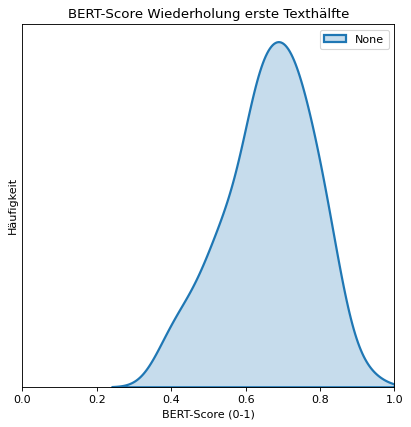

In [143]:
df_eval_custom = pd.read_csv("Z:\Training-Data\covers\eval_results_score.csv", index_col=0)
df_eval_org = pd.read_csv("Z:\Training-Data\covers\eval_results_org_score.csv", index_col=0)
df_eval_start_end = pd.read_csv("Z:\Training-Data\covers\eval_results_start_end.csv", index_col=0)

kdeplot_one(df_eval_custom["bertscore"], "BERT-Score Modell Evaluierung", "BERT-Score (0-1)", "Häufigkeit", "gpt2-custom")
kdeplot_one(df_eval_org["bertscore"], "BERT-Score Modell Evaluierung", "BERT-Score (0-1)", "Häufigkeit", "gpt2-custom")
kdeplot_two(df_eval_custom["bertscore"], df_eval_org["bertscore"], "Modell Evaluierung (BERT)", "BERT-Score (0-1)", "Häufigkeit", "gpt2-custom", "gpt2-org")
kdeplot_two(df_eval_custom["bleuscore"], df_eval_org["bleuscore"], "Modell Evaluierung (BLEU)", "BLEU-Score (0-1)", "Häufigkeit", "gpt2-custom", "gpt2-org")
print("mean:", statistics.mean(df_eval_custom["bertscore"]), "median:", statistics.median(df_eval_custom["bertscore"]), "stdev:", statistics.stdev(df_eval_custom["bertscore"]), sep=" ")
#kdeplot_one(df_eval_custom["bleuscore"], "BLEU-Score", "BLEU (0-1)", "Häufigkeit", "gpt2-custom")
#kdeplot_one(df_eval_org["bleuscore"], "BLEU-Score", "BLEU (0-1)", "Häufigkeit", "gpt2-custom")
print("mean:", statistics.mean(df_eval_custom["bleuscore"]), "median:", statistics.median(df_eval_custom["bleuscore"]), "stdev:", statistics.stdev(df_eval_custom["bleuscore"]), sep=" ")

print("org")
print("mean:", statistics.mean(df_eval_org["bertscore"]), "median:", statistics.median(df_eval_org["bertscore"]), "stdev:", statistics.stdev(df_eval_org["bertscore"]), sep=" ")
print("mean:", statistics.mean(df_eval_org["bleuscore"]), "median:", statistics.median(df_eval_org["bleuscore"]), "stdev:", statistics.stdev(df_eval_org["bleuscore"]), sep=" ")

kdeplot_one(df_eval_start_end["bertscore"], "BERT-Score Wiederholung erste Texthälfte", "BERT-Score (0-1)", "Häufigkeit", "None")

(array([  2.,   3.,   3.,   4.,   4.,   6.,   6.,   8.,   9.,   9.,  11.,
         12.,  13.,  17.,  17.,  20.,  21.,  23.,  24.,  26.,  28.,  32.,
         35.,  40.,  46.,  47.,  49.,  55.,  56.,  60.,  66.,  71.,  73.,
         75.,  80.,  82.,  83.,  87.,  89.,  90.,  94.,  97.,  98.,  98.,
         99.,  99.,  99.,  99.,  99., 100.]),
 array([0.38097876, 0.39184521, 0.40271167, 0.41357812, 0.42444457,
        0.43531102, 0.44617748, 0.45704393, 0.46791038, 0.47877684,
        0.48964329, 0.50050974, 0.51137619, 0.52224265, 0.5331091 ,
        0.54397555, 0.554842  , 0.56570846, 0.57657491, 0.58744136,
        0.59830782, 0.60917427, 0.62004072, 0.63090717, 0.64177363,
        0.65264008, 0.66350653, 0.67437299, 0.68523944, 0.69610589,
        0.70697234, 0.7178388 , 0.72870525, 0.7395717 , 0.75043816,
        0.76130461, 0.77217106, 0.78303751, 0.79390397, 0.80477042,
        0.81563687, 0.82650332, 0.83736978, 0.84823623, 0.85910268,
        0.86996914, 0.88083559, 0.89170204, 0.

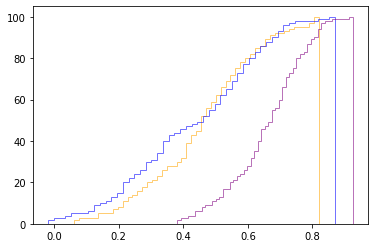

In [137]:
plt.hist(df_eval_custom["bertscore"], bins=50, cumulative=True, label='CDF DATA',
         histtype='step', alpha=0.55, color='orange')
plt.show
plt.hist(df_eval_org["bertscore"], bins=50, cumulative=True, label='CDF DATA',
         histtype='step', alpha=0.55, color='blue')

plt.hist(df_eval_start_end["bertscore"], bins=50, cumulative=True, label='CDF DATA',
         histtype='step', alpha=0.55, color='purple')

In [186]:
import sqlite3
con = sqlite3.connect(r"C:\Users\Philipp\PycharmProjects\tensorflow_conda\lyrics.db")
cur = con.cursor()
lyrics_filtered = cur.execute(f'''SELECT words, lyrics FROM lyrics''').fetchall()
tokens_a, words_a, dict_a = list(), list(), list()
for (words, lyrics) in lyrics_filtered:
    words_a.append(len(lyrics.split()))
    tokens_a.append(words)
    if words < 1024:
        dict_a.append(len(lyrics.split()))

In [194]:
from scipy import stats
print(stats.percentileofscore(tokens_a, 1024))

96.89581420218764


In [188]:
print(max(dict_a))
print(statistics.median(tokens_a))
print(statistics.median(words_a))

print(len(dict_a), len(words_a), sep="-")
print(float(len(dict_a) / float(len(words_a))))
# 0.9690162619581769

846
309.0
191.0
500120-516174
0.9688980847543658


In [ ]:
con = sqlite3.connect(r"C:\Users\Philipp\PycharmProjects\tensorflow_conda\lyrics.db")
con.row_factory = lambda cursor, row: row[0]
cur = con.cursor()
response = cur.execute(f'''SELECT words FROM lyrics ''').fetchall()
import numpy as np

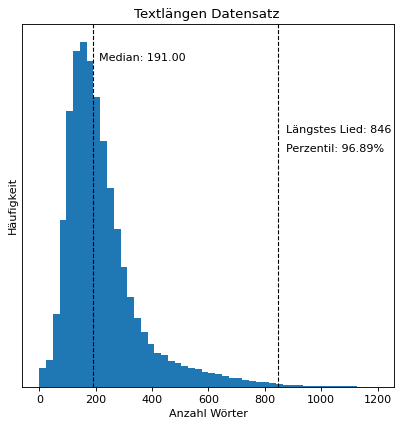

In [217]:
plt.figure(figsize=(6, 6), dpi=80)
plt.hist(words_a, bins=50, range=(0, 1200))
median = statistics.median(words_a)
#perz = float(len(dict_a) / float(len(words_a)))
#perz = 1 - len([i for i in words_a if i > 846]) / len(words_a)
perz = float(len(dict_a) / float(len(words_a)))

plt.axvline(median, color='k', linestyle='dashed', linewidth=1)
min_ylim, max_ylim = plt.ylim()
plt.text(median*1.1, max_ylim*0.9, 'Median: {:.2f}'.format(median))

plt.axvline(846, color='k', linestyle='dashed', linewidth=1)
min_ylim, max_ylim = plt.ylim()
plt.text(846+30, max_ylim*0.7, 'Längstes Lied: 846')
plt.text(846+30, max_ylim*0.65, 'Perzentil: {:.2f}%'.format(perz*100))
# plt.xlim(0.0, float(max(dict_a)))
plt.title('Textlängen Datensatz ')
plt.xlabel('Anzahl Wörter')
plt.ylabel("Häufigkeit")
plt.yticks([])
plt.show()


 max(response)=15359, statistics.mean(response)=372.13735290812787, statistics.median(response)=309.0, 0.9690162619581769
0.9690162619581769


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


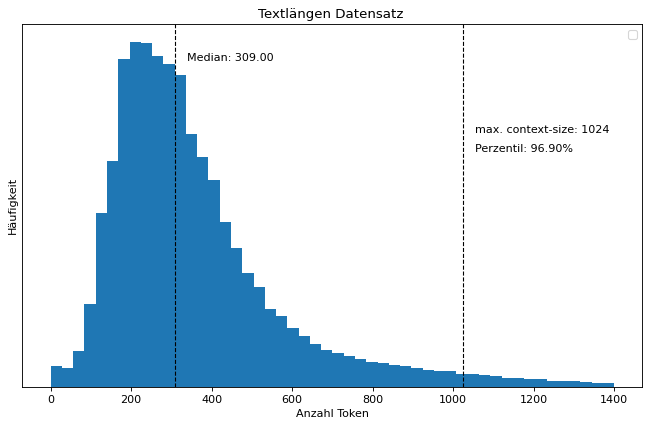

In [216]:


print(f" {max(response)=}, {statistics.mean(response)=}, {statistics.median(response)=}, {1 - len([i for i in response if i > 1024]) / len(response)}")
mean = statistics.mean(response)
median = statistics.median(response)
quantile = np.quantile(response, 0.995)
gpt_size = 1 - len([i for i in response if i > 1024]) / len(response)
print(gpt_size)
gpt_size_half = 1 - len([i for i in response if i > 512]) / len(response)

plt.figure(figsize=(10, 6), dpi=80)
plt.hist(response, bins=50, range=(0, 1400))
#fig = sns.kdeplot(df_gptdefault[key], shade=True, linewidth=2, label='Gpt2 Default')
#df_dataset["lines"].plot(kind = "hist", density=True, alpha=0.65, bins=40, range=(0, np.quantile(df_dataset[key], 0.995))) # change density to true, because KDE uses density

plt.axvline(median, color='k', linestyle='dashed', linewidth=1)
min_ylim, max_ylim = plt.ylim()
plt.text(median*1.1, max_ylim*0.9, 'Median: {:.2f}'.format(median))

plt.axvline(1024, color='k', linestyle='dashed', linewidth=1)
min_ylim, max_ylim = plt.ylim()
plt.text(1024+30, max_ylim*0.7, 'max. context-size: 1024')
plt.text(1024+30, max_ylim*0.65, 'Perzentil: {:.2f}%'.format(gpt_size*100))


#plt.axvline(512, color='k', linestyle='dashed', linewidth=1)
#min_ylim, max_ylim = plt.ylim()
#plt.text(512+40, max_ylim*0.8, 'gpt size half: {:.2f}%'.format(gpt_size_half*100))

#plt.axvline(np.quantile(response, 0.995), color='k', linestyle='dashed', linewidth=1 )
#min_ylim, max_ylim = plt.ylim()
#plt.text(quantile+40, max_ylim*0.6, '99,5 Quantil: {:.2f}'.format(quantile))


plt.legend(loc='upper right')
plt.title('Textlängen Datensatz ')
plt.xlabel('Anzahl Token')
plt.ylabel("Häufigkeit")
plt.yticks([])
plt.show()


In [151]:
import sqlite3
con = sqlite3.connect(r"C:\Users\Philipp\PycharmProjects\tensorflow_conda\lyrics.db")
con.row_factory = lambda cursor, row: row[0]
cur = con.cursor()
lyrics_filtered = cur.execute(f'''SELECT lang FROM lyrics''').fetchall()
amount_en, amount_es, amount_fr, amount_de, amount_other = 0, 0, 0, 0, 0
for lang in lyrics_filtered:
    match lang:
        case "en":
            amount_en += 1
        case "es":
            amount_es += 1
        case "fr":
            amount_fr += 1
        case "de":
            amount_de +=1
        case _:
            amount_other +=1



In [153]:
print(sizes)

[456476, 27541, 11359, 7350, 13448]


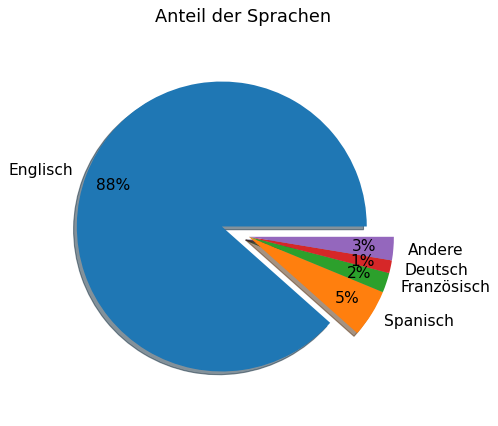

In [169]:
labels = "Englisch", "Spanisch", "Französisch", "Deutsch", "Andere"
sizes = [amount_en, amount_es, amount_fr, amount_de, amount_other]
explode = (0.2, 0, 0, 0, 0)

fig = plt.figure(figsize=(6, 6), dpi=80)
plt.pie(sizes, explode=explode, labels=labels, shadow=True, autopct='%1.0f%%', pctdistance=0.8, textprops={'fontsize': 14})
fig.suptitle("Anteil der Sprachen", fontsize=16)
#plt.title("Anteil der Sprachen")

plt.show()